# JERC coffea Tutorial

In [1]:
import awkward as ak
import numpy as np
import time
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema

import warnings
warnings.filterwarnings("ignore")

In [2]:
fname = "RunIISummer19UL17NanoAOD_QCD_Pt-15to7000_NANOAODSIM_JMECustomTuples.root"
events = NanoEventsFactory.from_root(fname, schemaclass=NanoAODSchema).events()

In [3]:
from coffea import processor, hist
class FancyJECL2L3Processor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat("dataset", "Primary dataset")
        eta_axis = hist.Bin("eta", r"$\eta$", 20, -5, 5)
        pt_axis = hist.Bin("pt", r"$p_{T}$ [GeV]", 
                           np.array([5,10,15,20,25,30,35,40,45,50,60,70,80,90,
                                     100,120,140,160,180,
                                     200,250,300,350,400,450,500,
                                     600,700,800,900,1000,
                                     1500,2000,3000,4000,5000]))
        dr_axis = hist.Bin("dr", r"$\delta (\eta)$", 20, 0., 1)
        m_axis = hist.Bin("m", r"$p_{T}$ [GeV]", 200, 0, 500)
        r_axis = hist.Bin("r", "RECO / GEN response", 200, 0, 5)
        
        self._accumulator = processor.dict_accumulator({
            'pt':hist.Hist("Counts", dataset_axis, pt_axis),
            'eta':hist.Hist("Counts", dataset_axis, eta_axis),
            'dr':hist.Hist("Counts", dataset_axis, dr_axis),
            'r_pt_ptveta':hist.Hist("Counts", dataset_axis, pt_axis, eta_axis, r_axis),
            'r_m_ptveta':hist.Hist("Counts", dataset_axis, pt_axis, eta_axis, r_axis),
            'r_m_ptvm':hist.Hist("Counts", dataset_axis, pt_axis, m_axis, r_axis),
            'cutflow': processor.defaultdict_accumulator(int),
        })
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, events):
        output = self.accumulator.identity()
        output['cutflow']['all events'] += len(events)
        
        selectedEvents = events[(ak.num(events.Jet) > 2)]

        ##leading jet
        #print(selectedEvents.Jet[:,0])
        
        ##leading two jets
        jet = selectedEvents.Jet[:,0:2]
        jet = ak.flatten(jet)
        ##only with genmatch
        jet = jet[~ak.is_none(jet.matched_gen)]
        ##only with good deltaR match
        jet = jet[jet.delta_r(jet.matched_gen)<0.2]
        
        ptresponse = jet.pt/jet.matched_gen.pt
        
        output['dr'].fill(dataset=selectedEvents.metadata["dataset"],
                            dr=jet.delta_r(jet.matched_gen))
        output['pt'].fill(dataset=selectedEvents.metadata["dataset"],
                            pt=jet.pt)
        output['eta'].fill(dataset=selectedEvents.metadata["dataset"], 
                                 eta=jet.eta)
        output['r_pt_ptveta'].fill( dataset=selectedEvents.metadata["dataset"], pt=jet.pt, eta=jet.eta, r=ptresponse)
        
        return output

    def postprocess(self, accumulator):
        return accumulator

In [4]:
samples = {
    "QCD": [fname]
}
tstart = time.time() 
output = processor.run_uproot_job(
    samples,
    "Events",
    FancyJECL2L3Processor(),
    processor.futures_executor,
    {"schema": NanoAODSchema},
)
elapsed = time.time() - tstart
print(output)
print("Events/s:", output['cutflow']['all events']/elapsed)

Preprocessing:   0%|          | 0/1 [00:00<?, ?file/s]

Processing:   0%|          | 0/6 [00:00<?, ?chunk/s]

{'pt': <Hist (dataset,pt) instance at 0x7f324929fa30>, 'eta': <Hist (dataset,eta) instance at 0x7f324929ff70>, 'dr': <Hist (dataset,dr) instance at 0x7f324929fa60>, 'r_pt_ptveta': <Hist (dataset,pt,eta,r) instance at 0x7f34b3fbd3d0>, 'r_m_ptveta': <Hist (dataset,pt,eta,r) instance at 0x7f34b3fbd490>, 'r_m_ptvm': <Hist (dataset,pt,m,r) instance at 0x7f34b3fbd4f0>, 'cutflow': defaultdict_accumulator(<class 'int'>, {'all events': 626100})}
Events/s: 30340.515339398917


In [5]:
print("\noutput: \n")
print(output)
print("\nhistogram and dictionary names: \n")
for key in output.keys():
    print(key)


output: 

{'pt': <Hist (dataset,pt) instance at 0x7f324929fa30>, 'eta': <Hist (dataset,eta) instance at 0x7f324929ff70>, 'dr': <Hist (dataset,dr) instance at 0x7f324929fa60>, 'r_pt_ptveta': <Hist (dataset,pt,eta,r) instance at 0x7f34b3fbd3d0>, 'r_m_ptveta': <Hist (dataset,pt,eta,r) instance at 0x7f34b3fbd490>, 'r_m_ptvm': <Hist (dataset,pt,m,r) instance at 0x7f34b3fbd4f0>, 'cutflow': defaultdict_accumulator(<class 'int'>, {'all events': 626100})}

histogram and dictionary names: 

pt
eta
dr
r_pt_ptveta
r_m_ptveta
r_m_ptvm
cutflow


In [6]:
import mplhep as hep
import matplotlib.pyplot as plt

In [7]:
EtaBins = output['r_pt_ptveta'].axis('eta')
EtaBinNums = len(output['eta'].values()[('QCD',)])

PtBins = output['r_pt_ptveta'].axis('pt')
PtBinNums = len(output['pt'].values()[('QCD',)])

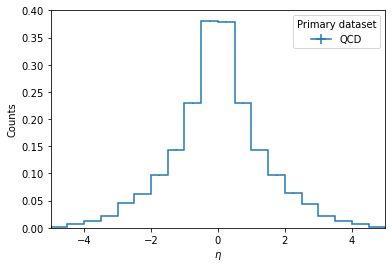

In [8]:
ax = hist.plotgrid(output['eta'], overlay="dataset", stack=False, density=True)

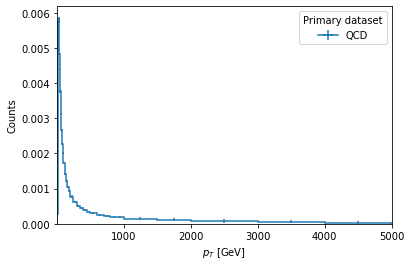

In [9]:
ax = hist.plotgrid(output['pt'], overlay="dataset", stack=False, density=True)

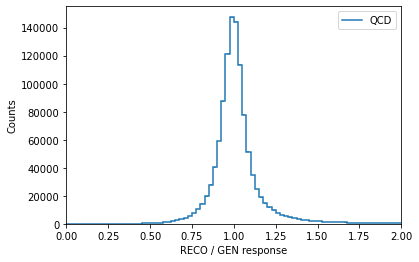

In [10]:
# jet energy response
fig, ax = plt.subplots(1, 1)

h_jer = output['r_pt_ptveta'].sum('dataset', 'eta').sum('pt')
ax = hist.plot1d(h_jer)
ax.set_xlim(0,2)
plt.legend(['QCD'])
plt.show()

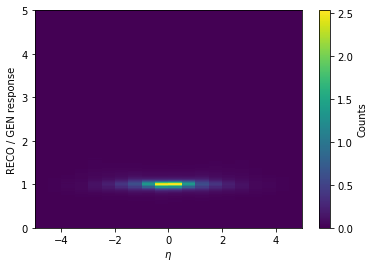

In [11]:
hist.plot2d(output['r_pt_ptveta'].sum('dataset', 'pt'), xaxis='eta', density=True);

Text(0, 0.5, 'RECO / GEN response')

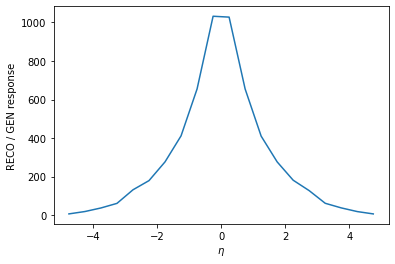

In [12]:
# jet energy response vs eta

fig, ax = plt.subplots(1, 1)

h = output['r_pt_ptveta'].sum('dataset', 'pt')

xaxis='eta'
yaxis='r'
xaxis = h.axis(xaxis)
yaxis = h.axis(yaxis)
xoverflow='none'
xedges = xaxis.edges(overflow=xoverflow)
xcenters = xaxis.centers(overflow=xoverflow)

ax.plot(xcenters, np.average(h.values()[()], axis=1))
ax.set_xlabel(xaxis.label)
ax.set_ylabel(yaxis.label)

Text(0, 0.5, 'RECO / GEN response')

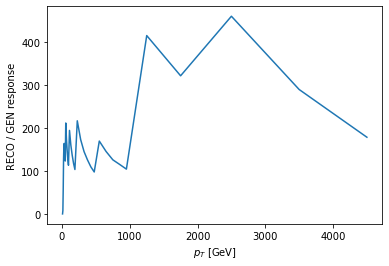

In [13]:
# jet energy response vs pt

fig, ax = plt.subplots(1, 1)

h = output['r_pt_ptveta'].sum('dataset').sum('eta')

xaxis='pt'
yaxis='r'
xaxis = h.axis(xaxis)
yaxis = h.axis(yaxis)
xoverflow='none'
xedges = xaxis.edges(overflow=xoverflow)
xcenters = xaxis.centers(overflow=xoverflow)

ax.plot(xcenters, np.average(h.values()[()], axis=1))
ax.set_xlabel(xaxis.label)
ax.set_ylabel(yaxis.label)